In [290]:
import pandas as pd
from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('fivethirtyeight')

In [291]:
roman = pd.read_csv('./model_data.csv', index_col=0)
roman = roman.drop(list(roman.loc[(roman['current_price'] < 3)| 
                          (roman['current_price']> 1000)].index), axis=0).reset_index(drop=True)

In [292]:
words = roman['URLTitle']

In [293]:
stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def cleaner(title):
    """ This function accepts a string, removes any preceding number, removes stopwords,
    removes any non-alphanumeric, lemmatizes, and then return the words as a joined string"""
    title_2 = re.sub(r'^\d+', " ", title)
    tokenizer = RegexpTokenizer(r'\w+|\d+')
    no_chars = re.sub(r"[^a-zA-Z0-9]", " ", title_2)
    no_chars_2 = re.sub(r"\b0+[0-9]+|\b[a-z][0-9]+", "", no_chars)
    titles = tokenizer.tokenize(no_chars_2.lower())
    lst = [word for word in titles if word not in stop]
    lemons = [lemmatizer.lemmatize(word) for word in lst]
    final = ' '.join(lemons)
    return final

In [294]:
cleaned_words = words.apply(cleaner)

In [295]:
cvec = CountVectorizer()
cvec.fit(cleaned_words)
cvecdata = cvec.transform(cleaned_words)

In [296]:
feature_df = pd.DataFrame(cvecdata.todense(), 
                           columns=cvec.get_feature_names())

In [297]:
feature_df.T.sum(axis=1).sort_values(ascending=False).head(10)

coin           13601
roman          13540
ancient        10119
silver          2873
ad              2495
constantine     2322
authentic       2301
empire          1931
great           1925
bronze          1870
dtype: int64

In [298]:
tf_transformer = TfidfTransformer().fit(cvecdata)
#sublinear_tf=True
word_vector = tf_transformer.transform(cvecdata)

# BASIC LR MODEL with just the title_vector

In [299]:
X = word_vector
y = np.log(roman['current_price'].values)

In [300]:
def basic_linear_model(X, y, model):
    """basic linear model that takes in features and response variable,
    prints r-squared, graphs predicted vs. y-test, and returns predicted and actual
    test values"""
    lr = model()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    lr.fit(X_train, y_train)
    print('The R-squared score: ', lr.score(X_test, y_test))
    preds = lr.predict(X_test)
    fig, ax = plt.subplots(figsize=(15,7))
    plt.scatter(np.arange(len(preds)), np.sort(preds), alpha=0.5, c='r', label='predictions')
    plt.scatter(np.arange(len(preds)), np.sort(y_test), alpha=0.5, c='g', label='true values')
    plt.legend().set_alpha(1)
    plt.show()
    return y_test, preds

The R-squared score:  0.4527248135513021


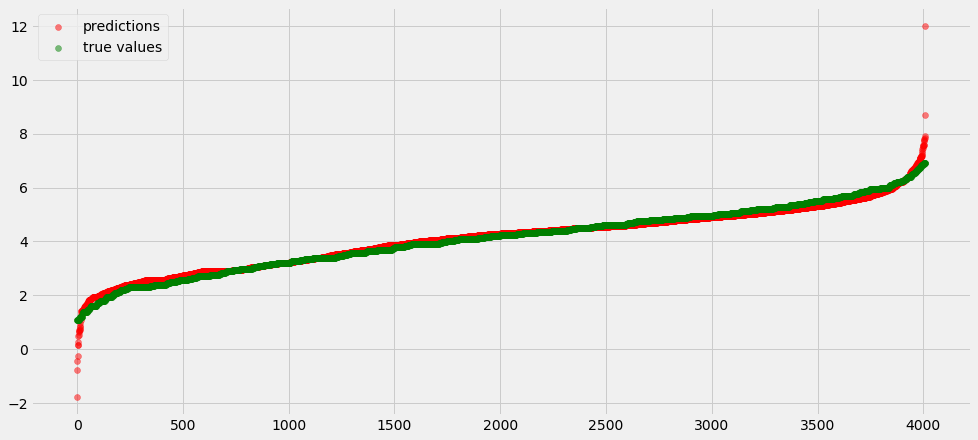

In [301]:
y_test, preds = basic_linear_model(X, y, LinearRegression)

In [302]:
def baseline_SSE(preds, y_test):
    """Prints the sum of squared errors for baseline and model and then gives the percentage
    improvement (or decline)"""
    baseline = np.array([y_test.mean() for x in range(len(y_test))])
    print(np.sum((preds - y_test)**2))
    print(np.sum((baseline - y_test)**2))
    print('The model is %.2f percent better than the baseline' % ((np.sum((baseline - y_test)**2) -
                                                          np.sum((preds - y_test)**2))/
                                                         np.sum((baseline - y_test)**2)*100))

baseline_SSE(preds, y_test)

3194.283407375074
5836.704251298098
The model is 45.27 percent better than the baseline


# Basic model with  dummies/time/demand features

In [303]:
roman = roman.drop(['URLTitle', 'itemId'], axis=1)

y = np.log(roman['current_price'].values)
X = roman.drop('current_price', axis=1)

The R-squared score:  0.5671620600667917


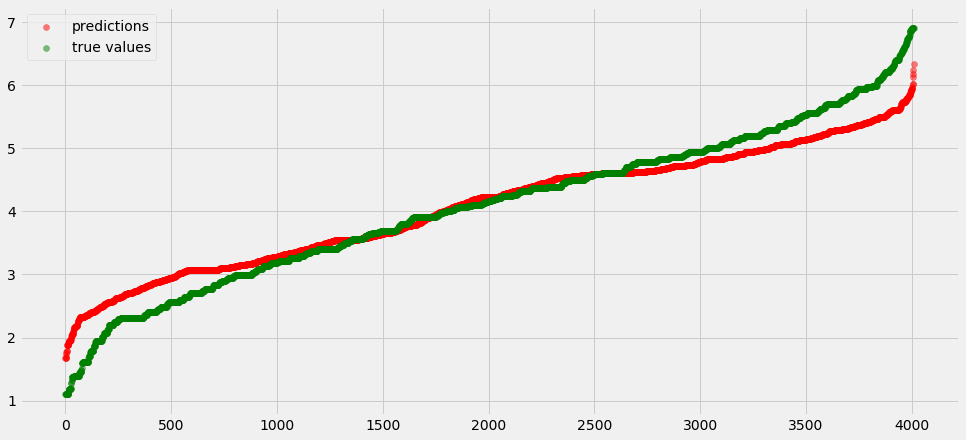

In [304]:
y_test, preds = basic_linear_model(X, y, LinearRegression)

In [305]:
baseline_SSE(preds, y_test)

2584.1751626695227
5970.306491774472
The model is 56.72 percent better than the baseline


# Models using Random Forest Regressor

The R-squared score:  0.707492800325613


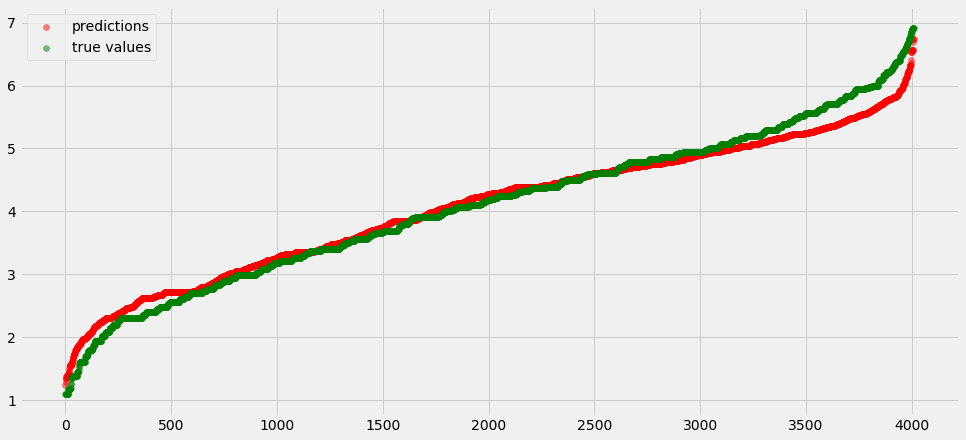

In [306]:
#FULL cleaned feature set 
y = np.log(roman['current_price'].values)
X = roman.drop('current_price', axis=1)

y_test, preds = basic_linear_model(X, y, RandomForestRegressor)

In [308]:
baseline_SSE(preds, y_test)

1751.1472955476688
5986.681003055688
The model is 70.75 percent better than the baseline


The R-squared score:  0.6617897232054862


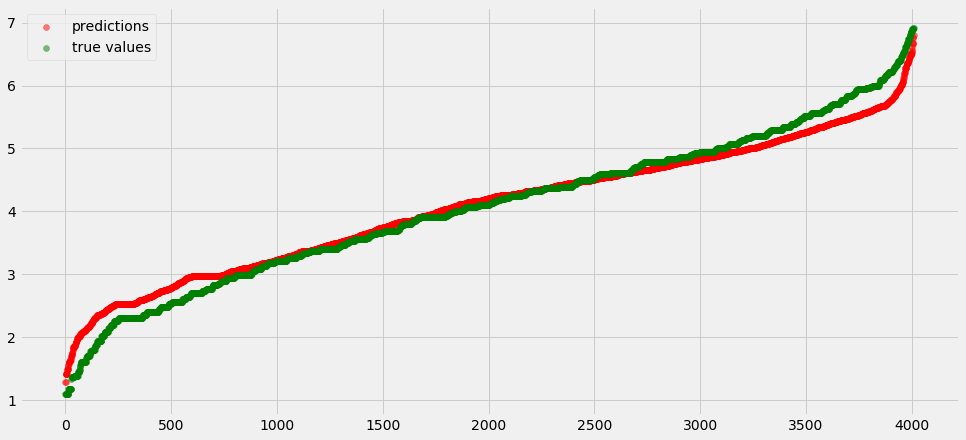

In [309]:
#MODEL using title vector

X = word_vector
y = np.log(roman['current_price'].values)

y_test, preds = basic_linear_model(X, y, RandomForestRegressor)

In [310]:
baseline_SSE(preds, y_test)

1982.5754118126065
5861.960880086322
The model is 66.18 percent better than the baseline
